In [1]:
import pandas as pd
import numpy as np
import torch
from torch import nn

In [2]:
device = "cude" if torch.cuda.is_available() else "cpu"

In [3]:
!pip install kaggle
from google.colab import files
files.upload()

!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

!kaggle competitions download -c digit-recognizer -p /content/data

Saving kaggle.json to kaggle.json
 52% 8.00M/15.3M [00:00<00:00, 83.3MB/s]
100% 15.3M/15.3M [00:00<00:00, 58.9MB/s]


In [4]:
import zipfile

# Path to ZIP file
zip_path = 'data/digit-recognizer.zip'

# Open ZIP file
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    # Extract the desired files
    with zip_ref.open('sample_submission.csv') as sample_file, \
         zip_ref.open('test.csv') as test_file, \
         zip_ref.open('train.csv') as train_file:

        # Load the files into Pandas DataFrames
        sample_submission = pd.read_csv(sample_file)
        test_data = pd.read_csv(test_file)
        train_data = pd.read_csv(train_file)

In [5]:
len(train_data), len(test_data)

(42000, 28000)

## Inspecting and manipulating data

In [6]:
# See the first training example
image = train_data.iloc[0]
image

,0
label,1
pixel0,0
pixel1,0
pixel2,0
pixel3,0
...,...
pixel779,0
pixel780,0
pixel781,0
pixel782,0


In [7]:
labels = train_data['label']
images = train_data.drop(['label'], axis=1)
images.shape, labels.shape

((42000, 784), (42000,))

In [8]:
class_names = ['zero', 'one', 'two', 'three', 'four', 'five', 'six', 'seven', 'eight', 'nine']
class_to_idx = dict(zip(class_names, list(set(labels))))
class_names, class_to_idx

(['zero',
  'one',
  'two',
  'three',
  'four',
  'five',
  'six',
  'seven',
  'eight',
  'nine'],
 {'zero': 0,
  'one': 1,
  'two': 2,
  'three': 3,
  'four': 4,
  'five': 5,
  'six': 6,
  'seven': 7,
  'eight': 8,
  'nine': 9})

In [9]:
images

,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41995,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
41996,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
41997,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
41998,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


## Converting DataFrame to Dataset

In [10]:
from torch.utils.data import Dataset

class DataFrameDataset(Dataset):

  has_label = False

  def __init__(self, dataframe, has_label_column):
    """
    Args:
        dataframe (pd.DataFrame): The source DataFrame.
        feature_columns (list): List of column names to be used as features.
        label_column (str): Column name to be used as the label.
    """
    self.dataframe = dataframe.copy()
    self.features = self.dataframe.drop(['label'], axis=1).values if has_label_column else self.dataframe.values
    self.has_label = has_label_column
    if has_label_column:
      self.labels = dataframe['label'].values

  def __len__(self):
    # Return the number of samples in the dataset
    return len(self.dataframe)

  def __getitem__(self, idx):
    # Generate one sample of data
    features = self.features[idx]
    if self.has_label:
      label = self.labels[idx]
      return torch.tensor(features, dtype=torch.float32).view(1, 28, 28), torch.tensor(label, dtype=torch.int64)
    else:
      return torch.tensor(features, dtype=torch.float32).view(1, 28, 28)


In [11]:
from sklearn.model_selection  import train_test_split

train_data_sample, test_data_sample = train_test_split(train_data, test_size=0.2)

In [12]:
train_dataset = DataFrameDataset(train_data, True)
test_dataset = DataFrameDataset(test_data, False)

## Preparing DataLoader

In [13]:
from torch.utils.data import DataLoader

# Setup the batch size hyperparameter
BATCH_SIZE = 32

# Turn datasets into iterables
train_dataloader = DataLoader(
    dataset=train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True
)

test_dataloader = DataLoader(
    dataset=test_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False
)

train_dataloader, test_dataloader

(<torch.utils.data.dataloader.DataLoader at 0x7daafa962290>,
 <torch.utils.data.dataloader.DataLoader at 0x7daafa962c20>)

In [14]:
train_features_batch, train_labels_batch = next(iter(train_dataloader))
train_features_batch.shape, train_labels_batch.shape

(torch.Size([32, 1, 28, 28]), torch.Size([32]))

(torch.Size([1, 28, 28]), tensor(9), torch.Size([]))

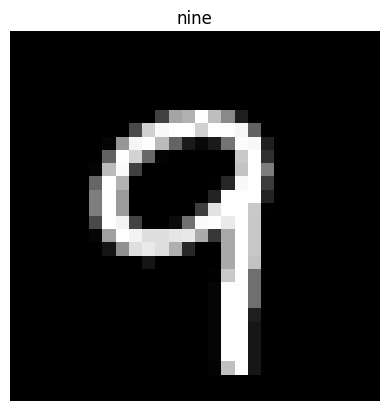

In [15]:
import matplotlib.pyplot as plt

# Show a sample
random_idx = torch.randint(0, len(train_features_batch), size=[1]).item()
img, label = train_features_batch[random_idx], train_labels_batch[random_idx]
plt.imshow(img.squeeze(), cmap="gray")
plt.title(class_names[int(label.item())])
plt.axis(False)
img.shape, label, label.shape

## Building Model

In [16]:
class Model(nn.Module):
  def __init__(self, input_shape: int, output_shape: int, hidden_units: int):
    super().__init__()
    self.conv_block_1 = nn.Sequential(
        nn.Conv2d(in_channels=input_shape,
                  out_channels=hidden_units,
                  kernel_size=3,
                  padding=1,
                  stride=1),
        nn.ReLU(),
        nn.Conv2d(in_channels=hidden_units,
                  out_channels=hidden_units,
                  kernel_size=3,
                  padding=1,
                  stride=1),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2)
    )
    self.conv_block_2 = nn.Sequential(
        nn.Conv2d(in_channels=hidden_units,
                  out_channels=hidden_units,
                  kernel_size=3,
                  padding=1,
                  stride=1),
        nn.ReLU(),
        nn.Conv2d(in_channels=hidden_units,
                  out_channels=hidden_units,
                  kernel_size=3,
                  padding=1,
                  stride=1),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2)
    )
    self.classifier = nn.Sequential(
        nn.Flatten(),
        nn.Linear(in_features=hidden_units*7*7,
                  out_features=output_shape)
    )

  def forward(self, x):
    return self.classifier(self.conv_block_2(self.conv_block_1(x)))

model = Model(input_shape=1,
              hidden_units=10,
              output_shape=len(class_names)).to(device)
model

Model(
  (conv_block_1): Sequential(
    (0): Conv2d(1, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_block_2): Sequential(
    (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=490, out_features=10, bias=True)
  )
)

## Setup loss function and optimizer

In [18]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(params=model.parameters(), lr=0.003)

In [19]:
def accuracy_fn(y_true, y_pred):
  correct = torch.eq(y_true, y_pred).sum().item()
  acc = (correct / len(y_pred)) * 100
  return acc

In [20]:
def train_step(model: torch.nn.Module,
               data_loader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               optimizer: torch.optim.Optimizer,
               accuracy_fn,
               device: torch.device = device):

  train_loss, train_acc = 0, 0
  model.train()

  for batch, (X, y) in enumerate(data_loader):
    X, y = X.to(device), y.to(device)

    y_pred = model(X)
    loss = loss_fn(y_pred, y)
    train_loss += loss # accumulate train loss
    train_acc += accuracy_fn(y_true=y, y_pred=y_pred.argmax(dim=1))

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

  # Divide total train loss and acc by length of train dataloader
  train_loss /= len(data_loader)
  train_acc /= len(data_loader)
  print(f"Train loss: {train_loss:.5f} | Train accuracy: {train_acc:.5f}")


def test_step(model: torch.nn.Module,
               data_loader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               accuracy_fn,
               device: torch.device = device):
  ### Testing
  test_loss, test_acc = 0, 0
  model.eval()
  with torch.inference_mode():
    for X, y in data_loader:
      X, y = X.to(device), y.to(device)
      test_pred = model(X)
      test_loss += loss_fn(test_pred, y)
      test_acc += accuracy_fn(y_true=y, y_pred=test_pred.argmax(dim=1))

    # Calculate test loss/accuracy average per batch
    test_loss /= len(data_loader)
    test_acc /= len(data_loader)

    # Print out
    print(f"Test loss: {test_loss:.5f} | Test accuracy: {test_acc:.5f}")

In [21]:
epochs = 5
for epoch in range(epochs):
  print(f"Epoch: {epoch}\n-----------")
  train_step(model=model,
             data_loader=train_dataloader,
             loss_fn=loss_fn,
             optimizer=optimizer,
             accuracy_fn=accuracy_fn,
             device=device)
  # test_step(model=model,
  #            data_loader=test_dataloader,
  #            loss_fn=loss_fn,
  #            accuracy_fn=accuracy_fn,
  #            device=device)


Epoch: 0
-----------
Train loss: 0.24897 | Train accuracy: 92.23391
Epoch: 1
-----------
Train loss: 0.09322 | Train accuracy: 97.15585
Epoch: 2
-----------
Train loss: 0.07062 | Train accuracy: 97.81750
Epoch: 3
-----------
Train loss: 0.05762 | Train accuracy: 98.19117
Epoch: 4
-----------
Train loss: 0.05016 | Train accuracy: 98.45297


In [22]:
def save_model(model, filepath, save_state_dict=True):
    if save_state_dict:
        torch.save(model.state_dict(), filepath)
    else:
        torch.save(model, filepath)

In [23]:
save_model(model, 'digit_recognizer_model_0.pth', save_state_dict=True)

## Making predictions

In [24]:
next(iter(test_dataloader)).shape

torch.Size([32, 1, 28, 28])

In [25]:
model.eval()
test_pred = []
with torch.inference_mode():
  for X in test_dataloader:
    X = X.to(device)
    for i in range(len(model(X))):
      test_pred.append(model(X)[i].argmax())

In [26]:
for i in range(len(test_pred)):
  test_pred[i] = test_pred[i].item()

test_pred

[2,
 0,
 9,
 9,
 3,
 7,
 0,
 3,
 0,
 3,
 5,
 7,
 4,
 0,
 4,
 3,
 3,
 1,
 9,
 0,
 9,
 1,
 1,
 5,
 7,
 4,
 2,
 7,
 4,
 7,
 7,
 5,
 4,
 2,
 6,
 2,
 5,
 5,
 1,
 6,
 7,
 7,
 4,
 9,
 8,
 7,
 8,
 2,
 6,
 7,
 6,
 8,
 8,
 3,
 8,
 2,
 1,
 2,
 2,
 9,
 4,
 1,
 7,
 0,
 0,
 0,
 1,
 9,
 0,
 1,
 6,
 5,
 8,
 8,
 2,
 8,
 9,
 9,
 2,
 3,
 5,
 4,
 1,
 0,
 9,
 2,
 4,
 3,
 6,
 7,
 2,
 0,
 6,
 6,
 1,
 4,
 3,
 9,
 7,
 4,
 0,
 9,
 2,
 0,
 7,
 3,
 0,
 5,
 0,
 8,
 0,
 0,
 4,
 7,
 1,
 7,
 1,
 1,
 3,
 3,
 3,
 7,
 2,
 8,
 6,
 3,
 8,
 7,
 8,
 4,
 3,
 5,
 6,
 0,
 0,
 0,
 3,
 1,
 5,
 6,
 4,
 3,
 4,
 5,
 5,
 8,
 7,
 7,
 2,
 8,
 4,
 3,
 5,
 6,
 5,
 3,
 7,
 5,
 7,
 8,
 3,
 0,
 4,
 5,
 1,
 2,
 7,
 6,
 3,
 0,
 2,
 7,
 8,
 6,
 1,
 3,
 7,
 4,
 1,
 2,
 4,
 8,
 5,
 2,
 4,
 9,
 2,
 1,
 6,
 0,
 6,
 1,
 4,
 9,
 6,
 0,
 9,
 7,
 6,
 9,
 1,
 9,
 0,
 9,
 9,
 0,
 8,
 4,
 6,
 2,
 0,
 9,
 3,
 6,
 3,
 2,
 1,
 6,
 3,
 4,
 2,
 3,
 1,
 2,
 2,
 0,
 4,
 6,
 1,
 0,
 0,
 4,
 9,
 1,
 7,
 3,
 2,
 3,
 8,
 6,
 8,
 6,
 2,
 8,
 5,
 5,
 4,
 8,
 3,
 4,


In [27]:
# Create a range of integers from 1 to len(labels)
image_ids = range(1, len(test_pred) + 1)

# Create the DataFrame
df = pd.DataFrame({
    'ImageId': image_ids,
    'Label': test_pred
})

In [28]:
df.to_csv('digit_recognizer_submission.csv', index=False)